<a href="https://colab.research.google.com/github/bogdanlalu/tensorflow/blob/master/NLP/04_Train_on_Sarcasm_with_Embedings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sarcasm Headlines


Datased downloaded from https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/version/2

It was manually updated in Colab

# Load all data, create training and testing examples and lables

In [0]:
import json
import zipfile
from itertools import product

import numpy as np
import pandas as pd

import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
f_name = 'Sarcasm_Headlines_Dataset.json.zip'
archive = zipfile.ZipFile(f_name)
archive.extractall()

In [0]:
datafile = 'Sarcasm_Headlines_Dataset.json'

def get_json_data(f_name):
  sentences = []
  labels    = []
  with open(datafile, 'r') as f:
    lines = f.readlines()
    for line in lines:
      sentence = json.loads(line)['headline']
      label = json.loads(line)['is_sarcastic']
      sentences.append(sentence)
      labels.append(label)
  return sentences, labels

sentences, labels = get_json_data(datafile)

print("Num. sentences:", len(sentences))
print("Num. labels: ", len(labels))

Num. sentences: 26709
Num. labels:  26709


## Remove stopwords

### NOTE: consider encoding and training with and without stopwords. this means removing stopwords at encoding time (create a stopwords param for an encoding function

In [0]:
!wget --no-check-certificate \
    http://mlg.ucd.ie/files/datasets/stopwords.txt \
    -O stopwords.txt

--2020-05-14 13:15:37--  http://mlg.ucd.ie/files/datasets/stopwords.txt
Resolving mlg.ucd.ie (mlg.ucd.ie)... 137.43.93.132
Connecting to mlg.ucd.ie (mlg.ucd.ie)|137.43.93.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1780 (1.7K) [text/plain]
Saving to: ‘stopwords.txt’

stopwords.txt       100%[===================>]   1.74K  --.-KB/s    in 0s      

2020-05-14 13:15:38 (180 MB/s) - ‘stopwords.txt’ saved [1780/1780]



In [0]:
with open('stopwords.txt', 'r') as f:
  words = f.readlines()

stopwords = [w.replace('\n', '') for w in words]
print(len(stopwords), " stopwords")

300  stopwords


In [0]:
def clean_chars(sentences):
  """Removes special characters from a list of sentences."""
  special_chars = r'.!@£$%^&*()_+"={}[]:"|;\<>?,./`~`'
  parsed_sentences = []

  # go through each sentence
  # go through each char
  # check if char is not part of special_chars and if so, append it to a list of clean chars
  # join this list of clean chars to create words
  # append this list of words (clean sentence) to the list of new sentences which will be returned

  for sentence in sentences:
    clean_chars = []

    for char in sentence:
      if char not in special_chars:
        clean_chars.append(char)
  
    clean_sentence = ''.join(clean_chars)  # space is already a clean char
    parsed_sentences.append(clean_sentence)
  
  return parsed_sentences

In [0]:
def remove_stop_words(sentences, stopwords=['']):
  parsed_sentences = []

  for sentence in sentences:
    parsed_words = []

    for word in sentence.split(' '):
      if word.lower() not in stopwords:
        parsed_words.append(word.lower())

    parsed_sentence = ' '.join(parsed_words)
    parsed_sentence = parsed_sentence.replace ("  ", " ")
    parsed_sentences.append(parsed_sentence)

  return parsed_sentences

In [0]:
def get_num_words(corpus):
  sum = 0
  for document in corpus:
    sum += len(document.split(' '))
  print(sum)

In [0]:
# num words in complete sentences
get_num_words(sentences)

263026


In [0]:
sentences_clean_chars = clean_chars(sentences)
sentences = remove_stop_words(sentences_clean_chars, stopwords=stopwords)

In [0]:
# num words in sentences with stop words removed
get_num_words(sentences)

183061


**NOTE** In practice when predicting on completely new and unseen data, the same stopwords removal process needs to be applied

## Train test split

In [0]:
def train_test_split(sentences, labels, pct_train, shuffle=False, seed=None):
  
  size = int(pct_train * len(sentences))

  if shuffle==True:

    import random
    random.seed(seed)
    idx = list(range(len(sentences)))
    random.shuffle(idx)
    sentences = [sentences[i] for i in idx]
    labels    = [labels[i] for i in idx] 

  training_sentences = sentences[:size]
  training_labels    = np.array(labels[:size])

  testing_sentences  = sentences[size:]
  testing_labels     = np.array(labels[size:])

  print("train data:", len(training_sentences), len(training_labels))
  print("testing data:", len(testing_sentences), len(testing_labels))

  return training_sentences,training_labels, testing_sentences, testing_labels

In [0]:
training_sentences, training_labels, testing_sentences, testing_labels = train_test_split(sentences, 
                                                                                          labels, 
                                                                                          pct_train = 0.90, 
                                                                                          shuffle=True, 
                                                                                          seed=3)

train data: 24038 24038
testing data: 2671 2671


Class distribution

In [0]:
print(np.bincount(training_labels) / len(training_labels))
print(np.bincount(testing_labels) / len(testing_labels))

[0.5622764 0.4377236]
[0.54998128 0.45001872]


## Explore the data

In [0]:
for i in range(15):
  print(training_sentences[i], "\t", training_labels[i])
print("-" * 50)

for i in range(15):
  print(testing_sentences[i], "\t", testing_labels[i])

sterling won't get naacp award 	 0
growing black gay south 	 0
aleppo hit worst strikes months putin assad ignore plea 	 0
women business qa laura tenison founder managing director jojo maman bébé 	 0
alabama marriage equality tantrum slap face americans 	 0
pizza hut employee hanging shift 	 1
clinton expecting collect white house security deposit 	 1
snapchat's snapcash peer-to-peer payment safe 	 0
eye surgery lets abused dog see rescuer first time 	 0
competent nonprofit boards strategic planning 	 0
intensifies empty-threat campaign against north korea 	 1
notion 'ferguson effect' policing problematic 	 0
fall inversions 	 0
iran releases 4 american prisoners months top-secret negotiations 	 0
cia torture's immeasurable damage global leadership 	 0
--------------------------------------------------
report pretty incredible americans entrusted driving cars 	 1
1 good movie netflix adds week 	 0
good cop avid-stamp-collector cop routine working 	 1
sleep target's chic modern home co

* We determine the length of the vocabulary in the training data to inform how 
large the vocabulary size should when encoding the sentences. 
* I would like to start by trying an encoding vocabulary size of 5 - 10% of the size of the training data vocabulary. This will be fine-tuning based on the model training and validation accuracy.

* We also determine the number of words in the largest sentence to inform padding and truncating when encoding the sentences

*The testing (new) data should remain hidden so we calculate the vocabulary size
just for the training data

In [0]:
sentences_lengths = [len(sentence.split(' ')) for sentence in sentences]
training_lengths = [len(sentence.split(' ')) for sentence in training_sentences]
testing_lengths = [len(sentence.split(' ')) for sentence in testing_sentences]

# TODO: the code below seems inefficient, think about optimising it

words_in_training_sentences = []
for s in training_sentences:
  for word in s.split(' '):
    words_in_training_sentences.append(word)

print("Num words in training sentences:", len(words_in_training_sentences))
print("Num unique words in training sentences:", len(set(words_in_training_sentences)))

#print("Max num words all sentences:", max(sentences_lengths)) # do not look at this :)
print(f"The longest training sentence has {max(training_lengths)} words")
print(f"The shortest training sentence has {min(training_lengths)} words")
#print("Max num words testing:", max(testing_lengths))  # do not look at this :)

Num words in training sentences: 164857
Num unique words in training sentences: 30056
The longest training sentence has 27 words
The shortest training sentence has 1 words


* Sentences have up to 15 words in general with very few exceptions.
* Over 90% of senences have up to 10 words
* These statistics could be help inform the decision on how to pad & truncate sentences when encoding
* **Note** There are also sentences of 1-3 words. Some of these short sentences have keywords that could be helpful in clasifying, but I am wary of using sentences of only 1 word for training
* **TODO** Consider excluding sentences of 1 word. In practice when classifying new data we could impose a restriction of at least 2 words

In [0]:
lengths_df = pd.DataFrame({'lengths': training_lengths})

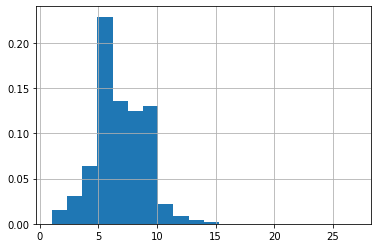

In [0]:
lengths_df['lengths'].hist(bins = 20, density=True)

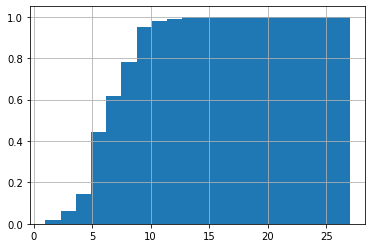

In [0]:
lengths_df['lengths'].hist(bins = 20, density=True, cumulative=True)

In [0]:
lengths_df['lengths'].value_counts(dropna=False, sort=True, ascending=True)

27       1
26       1
21       1
18       2
25       2
19       2
17       4
16       7
15      26
14      44
1       50
13     131
12     281
2      439
11     676
3      970
10    1491
4     1992
9     2586
5     3091
8     3905
6     4075
7     4261
Name: lengths, dtype: int64

In [0]:
very_short_sentences = [s for s in training_sentences if len(s.split(' ')) <=2]

In [0]:
for s in very_short_sentences:
  print(s)

fall inversions
mess
hamilton brouhaha
commas turning
website humiliating
expected nap
podiatrist jerk
alcoholic recovered
prejudice discriminate
james bond
quantum lip
brotherly advice
epiphany
pilgrimage india
christian closet
school sign
guess
religion 'extremist'
empire destruction
terrorists attack
roommate cycling
gift choice
it's ivanka
watch conventions
reset button
deserve better

lost 2011
déjà vu
tennis racket
dress sexiest
government problem
seeing humanity
life ocd
money life
conundrum midterms
two non-interventionists
modest proposal
importance vision
objection honor
sunday roundup
real world
growing transylvania
acknowledge move
london life
sunday roundup
sunday roundup
speaking 'rigged'
yorker murdered
report
naked truth
betelgeuse supernova
kids sexy
resisting trump
parents part
swear local
truth fiction
safer
divest double
time different
worth america
importance trying
knowing hillary
girls
check deer
today journalists
sanders phenomenon
waking dreaming
paradox addict

# Simple training

## Encode sentences

In [0]:
# Hyperparameters for encoding and training 

vocab_size = 1500        # Around 5% of the trining vocab size
oov_token = '<OOV>'
padding_type = 'post'
truncating_type = 'post'
max_sentence_len = 10     # Over 90% of training sentences have up to 10 words 
embedding_dimensions = 8
num_epochs = 10           # For training the model

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [0]:
print("Num unique words in training sentences:", len(set(words_in_training_sentences)))
print("Total words in the word index after tokenizing: ", len(word_index.items()))
print("Num. words in the tokenizer: ", tokenizer.num_words)

Num unique words in training sentences: 30056
Total words in the word index after tokenizing:  28257
Num. words in the tokenizer:  1500


In [0]:
print(word_index)

{'<OOV>': 1, 'trump': 2, 'man': 3, 'just': 4, 'report': 5, 'one': 6, 'year': 7, 'area': 8, 'donald': 9, 'says': 10, 'first': 11, 'day': 12, 'woman': 13, 'time': 14, "trump's": 15, 'old': 16, 'get': 17, 'obama': 18, 'people': 19, 'life': 20, 'house': 21, 'white': 22, 'women': 23, 'i': 24, 'back': 25, 'clinton': 26, 'world': 27, 'before': 28, '5': 29, 'way': 30, 'americans': 31, 'gop': 32, 'family': 33, 'black': 34, 'study': 35, 'school': 36, "it's": 37, 'bill': 38, 'years': 39, 'watch': 40, 'best': 41, 'american': 42, 'police': 43, 'really': 44, '3': 45, 'state': 46, 'know': 47, 'show': 48, 'home': 49, 'president': 50, 'finds': 51, 'nation': 52, 'video': 53, 'health': 54, 'death': 55, 'good': 56, 'against': 57, 'going': 58, 'things': 59, '10': 60, 'hillary': 61, 'mom': 62, 'big': 63, 'gets': 64, 'campaign': 65, 'love': 66, "'the": 67, 'need': 68, 'right': 69, 'party': 70, 'getting': 71, 'parents': 72, 'high': 73, 'little': 74, 'take': 75, 'work': 76, 'kids': 77, 'court': 78, 'change': 7

In [0]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences  = tokenizer.texts_to_sequences(testing_sentences)

padded_training_seq = pad_sequences(training_sequences, 
                                    maxlen=max_sentence_len,
                                    padding=padding_type,
                                    truncating=truncating_type)

padded_testing_seq = pad_sequences(testing_sequences, 
                                    maxlen=max_sentence_len,
                                    padding=padding_type,
                                    truncating=truncating_type)

In [0]:
training_sequences[:3]

[[1, 133, 17, 1, 914],
 [1039, 34, 83, 393],
 [1, 498, 608, 1, 419, 1001, 1, 1, 1]]

In [0]:
padded_training_seq[:3]

array([[   1,  133,   17,    1,  914,    0,    0,    0,    0,    0],
       [1039,   34,   83,  393,    0,    0,    0,    0,    0,    0],
       [   1,  498,  608,    1,  419, 1001,    1,    1,    1,    0]],
      dtype=int32)

In [0]:
padded_training_seq.shape

(24038, 10)

In [0]:
testing_sequences[:3]

[[5, 230, 1026, 31, 1, 578, 1348],
 [223, 56, 169, 840, 704, 113],
 [56, 576, 1, 1, 1, 576, 1, 327]]

In [0]:
padded_testing_seq[:3]

array([[   5,  230, 1026,   31,    1,  578, 1348,    0,    0,    0],
       [ 223,   56,  169,  840,  704,  113,    0,    0,    0,    0],
       [  56,  576,    1,    1,    1,  576,    1,  327,    0,    0]],
      dtype=int32)

In [0]:
padded_testing_seq.shape

(2671, 10)

## Train and validate a classifier on embeddings

In [0]:
model = Sequential([
                    tensorflow.keras.layers.Embedding(vocab_size, 
                                                      embedding_dimensions, 
                                                      input_length=max_sentence_len),
                    tensorflow.keras.layers.GlobalAveragePooling1D(),
                    tensorflow.keras.layers.Dense(2, activation='relu'),
                    tensorflow.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 10, 8)             12000     
_________________________________________________________________
global_average_pooling1d_17  (None, 8)                 0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 3         
Total params: 12,021
Trainable params: 12,021
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(padded_training_seq, training_labels,
                    epochs=num_epochs, validation_data=(padded_testing_seq, testing_labels))

Epoch 1/10
752/752 [==============================] - 1s 1ms/step - loss: 0.6628 - accuracy: 0.5730 - val_loss: 0.6255 - val_accuracy: 0.6567
Epoch 2/10
752/752 [==============================] - 1s 1ms/step - loss: 0.5670 - accuracy: 0.7304 - val_loss: 0.5446 - val_accuracy: 0.7368
Epoch 3/10
752/752 [==============================] - 1s 1ms/step - loss: 0.4996 - accuracy: 0.7736 - val_loss: 0.5129 - val_accuracy: 0.7585
Epoch 4/10
752/752 [==============================] - 1s 1ms/step - loss: 0.4678 - accuracy: 0.7857 - val_loss: 0.5011 - val_accuracy: 0.7574
Epoch 5/10
752/752 [==============================] - 1s 1ms/step - loss: 0.4518 - accuracy: 0.7908 - val_loss: 0.4972 - val_accuracy: 0.7559
Epoch 6/10
752/752 [==============================] - 1s 1ms/step - loss: 0.4429 - accuracy: 0.7929 - val_loss: 0.4962 - val_accuracy: 0.7619
Epoch 7/10
752/752 [==============================] - 1s 1ms/step - loss: 0.4374 - accuracy: 0.7942 - val_loss: 0.4972 - val_accuracy: 0.7615
Epoch 

## Plot results

In [0]:
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

Plot accuracy

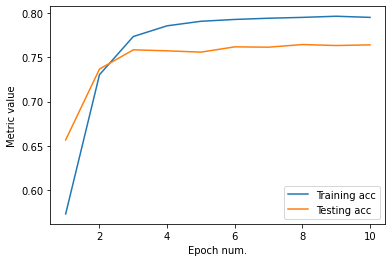

In [0]:
plt.figure()
plt.plot(range(1, num_epochs+1), training_acc, label = 'Training acc')
plt.plot(range(1, num_epochs+1), validation_acc, label = 'Testing acc')

plt.xlabel('Epoch num.')
plt.ylabel('Metric value')
plt.legend()

Plot loss

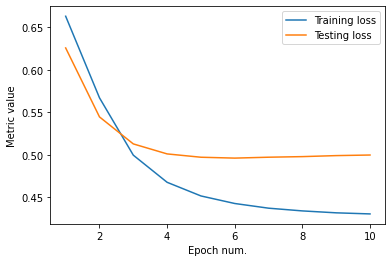

In [0]:
plt.figure()
plt.plot(range(1, num_epochs+1), training_loss, label = 'Training loss')
plt.plot(range(1, num_epochs+1), validation_loss, label = 'Testing loss')

plt.xlabel('Epoch num.')
plt.ylabel('Metric value')
plt.legend()

# Grid search style training

## TODO: Implement a grid search that loops through vocab_size, max sentence length

- train
- log accuracy and loss for each combination
- plot a chart to show performance across each combination all at once (like a scatter plot). X axis is train accuracy, Y axis is test accuracy

In [0]:
def grid_train(X_train, y_train, 
               X_test, y_test,
               num_epochs=10, 
               num_neurons=5,
               vocab_size = None,
               oov_token = '<OOV>',
               padding_type = 'post',
               truncating_type = 'post',
               max_sentence_len = None, 
               embedding_dimensions = None):
  
  training_history = {}
  
  validation_accuracies = []

  params_grid = list(product(vocab_size, max_sentence_len, embedding_dimensions))
  n_models = len(params_grid)
  print(f"Training {n_models} models at {num_epochs} epochs each...")

  for i, params in enumerate(params_grid):
    v_size = params[0]  # Vocabulary size 
    s_len  = params[1]  # Max sentence length
    dim    = params[2]  # Num. embedding dimensions

    # Encoding and Padding
    tokenizer = Tokenizer(num_words=v_size, oov_token=oov_token)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index

    training_sequences = tokenizer.texts_to_sequences(X_train)
    testing_sequences  = tokenizer.texts_to_sequences(X_test)

    padded_training_seq = pad_sequences(training_sequences, 
                                        maxlen=s_len,
                                        padding=padding_type,
                                        truncating=truncating_type)
    

    padded_testing_seq = pad_sequences(testing_sequences, 
                                        maxlen=s_len,
                                        padding=padding_type,
                                        truncating=truncating_type)

    # Define model architecture and compile
    model = Sequential([
                    tensorflow.keras.layers.Embedding(v_size, dim, input_length=s_len),
                    tensorflow.keras.layers.GlobalAveragePooling1D(),
                    tensorflow.keras.layers.Dense(num_neurons, activation='relu'),
                    tensorflow.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


    # Train the classifier
    history = model.fit(padded_training_seq, 
                        y_train,
                        epochs=num_epochs, 
                        validation_data=(padded_testing_seq, y_test),
                        verbose=0)
    print(f"Trained {i+1} / {n_models} models.")
    
    # Log performance metrics
    train_acc_hist = history.history['accuracy']
    val_acc_hist = history.history['val_accuracy']

    train_loss_hist = history.history['loss']
    val_loss_hist = history.history['val_loss']

    training_history[f'model_{i+1}'] = {
        'vocab_size': v_size,
        'max_sentence_len': s_len,
        'embedding_dimensions': dim,
        'neurons_in_hidden_layer': num_neurons,
        'last3_train_acc': np.array(train_acc_hist[-3:]).mean(),
        'last3_val_acc': np.array(val_acc_hist[-3:]).mean(),
        'last3_train_loss': np.array(train_loss_hist[-3:]).mean(),
        'last3_val_loss': np.array(val_loss_hist[-3:]).mean(),
        }
    validation_accuracies.append(np.array(val_acc_hist[-3:]).mean())

  # Determine the hyperparameters that generated the highest validation accuracy
  max_val_acc = max(validation_accuracies)
  max_val_acc_idx = validation_accuracies.index(max_val_acc)

  best_model_num = max_val_acc_idx + 1
  best_model_params = training_history[f'model_{best_model_num}']
  best_model_val_acc = best_model_params['last3_val_acc']

  print("=" * 50)
  print(f"Model {best_model_num} had the highest avg val accuracy: {best_model_val_acc}")
  print(f"Vocabulary size: {best_model_params['vocab_size']}")
  print(f"Maximum sentence length: {best_model_params['max_sentence_len']}")
  print(f"Embedding dimensions: {best_model_params['embedding_dimensions']}")
  print("=" * 50)
  
  # Retrain the model with the best parameters
  print("Retraining the model with the best hyperparameters ")

  return training_history

In [0]:
# Hyperparameters for encoding and training 
vocab_size = [2000, 3000, 4000, 5000]
max_sentence_len = [10, 15]
embedding_dimensions = [8, 16, 32]

In [0]:
hist = grid_train(X_train=training_sentences, y_train=training_labels,
           X_test=testing_sentences, y_test=testing_labels,
           vocab_size=vocab_size,
           max_sentence_len=max_sentence_len,
           embedding_dimensions=embedding_dimensions)

Training 24 models at 10 epochs each...
Trained 1 / 24 models.
Trained 2 / 24 models.
Trained 3 / 24 models.
Trained 4 / 24 models.
Trained 5 / 24 models.
Trained 6 / 24 models.
Trained 7 / 24 models.
Trained 8 / 24 models.
Trained 9 / 24 models.
Trained 10 / 24 models.
Trained 11 / 24 models.
Trained 12 / 24 models.
Trained 13 / 24 models.
Trained 14 / 24 models.
Trained 15 / 24 models.
Trained 16 / 24 models.
Trained 17 / 24 models.
Trained 18 / 24 models.
Trained 19 / 24 models.
Trained 20 / 24 models.
Trained 21 / 24 models.
Trained 22 / 24 models.
Trained 23 / 24 models.
Trained 24 / 24 models.
Model 19 had the highest avg val accuracy: 0.7852240204811096
Vocabulary size: 5000
Maximum sentence length: 10
Embedding dimensions: 8
Retraining the model with the best hyperparameters 


## TODO: return the best model
## TODO: plot all accuracies from the grid search

In [0]:
hist

{'model_1': {'embedding_dimensions': 8,
  'last3_train_acc': 0.810896635055542,
  'last3_train_loss': 0.3960541784763336,
  'last3_val_acc': 0.7676275968551636,
  'last3_val_loss': 0.48497817913691205,
  'max_sentence_len': 10,
  'neurons_in_hidden_layer': 5,
  'vocab_size': 2000},
 'model_10': {'embedding_dimensions': 8,
  'last3_train_acc': 0.8388662338256836,
  'last3_train_loss': 0.3502527077992757,
  'last3_val_acc': 0.7827280759811401,
  'last3_val_loss': 0.47043858965237934,
  'max_sentence_len': 15,
  'neurons_in_hidden_layer': 5,
  'vocab_size': 3000},
 'model_11': {'embedding_dimensions': 16,
  'last3_train_acc': 0.8385334213574728,
  'last3_train_loss': 0.35177840789159137,
  'last3_val_acc': 0.7793585459391276,
  'last3_val_loss': 0.47919519742329914,
  'max_sentence_len': 15,
  'neurons_in_hidden_layer': 5,
  'vocab_size': 3000},
 'model_12': {'embedding_dimensions': 32,
  'last3_train_acc': 0.8380897045135498,
  'last3_train_loss': 0.35021792848904926,
  'last3_val_acc': 

# Get the embedding words and weights to plot them on tensorflow embedding projector https://projector.tensorflow.org/

In [0]:
embeddings_layer = model.layers[0]
weights = embeddings.get_weights()[0]
weights.shape

(5000, 16)

In [0]:
words_dict = {}

for k,v in word_index.items():
  words_dict[v] = k

In [0]:
with open('meta.tsv', 'w', encoding='utf-8') as f:
  for word_num in range(1, vocab_size):
    word = words_dict[word_num]
    f.write(word + "\n")

with open('vecs.tsv', 'w', encoding='utf-8') as f:
  # I think weights[0] is skipped in the loop since it might represent  
  # the weights of the padding token(0). 
  # Therfore, weights[1] aligns with reverse_word_index[1] and so on
  for word_num in range(1, vocab_size):             
    embeddings = weights[word_num]
    f.write('\t'.join([str(x) for x in embeddings]) + '\n')

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

# Error analysis - find patterns in sentences where prediction is incorrect

 -  look at precision and recall - use sklearn metrics, ROC? AUC? Decision threshold?

Predict on all training data (and testing data) and identify patterns in :
 - training sentences where the model cannon learn (to adjust training data) - eg key words or short sentences that lead to incorrect prediction
 - same as above for testing sentences - **BUT** if we adjust based on this we might leak some information and the impact the generalisability - consider using a train, validation, test split


# Predict on new data

In [0]:
new_sentences = ['Kangoroo bites man in a bar!', 
                  'Is climage change real? Politician says no.', 
                  'A good beer is life changing',
                 'Trump plays golf like grandma drinking a beer']

test_sentences_clean_chars = clean_chars(new_sentences)
test_sentences = remove_stop_words(test_sentences_clean_chars, stopwords=stopwords)

test_sent_seq = tokenizer.texts_to_sequences(test_sentences)
padded_test_seq = pad_sequences(test_sent_seq, 
                                maxlen=max_sentence_len, 
                                padding=padding_type,
                                truncating=truncating_type)

predictions = model.predict(padded_test_seq)

for i, s in enumerate(new_sentences):
  print(s, '\t', predictions[i])

Kangoroo bites man in a bar! 	 [0.8823618]
Is climage change real? Politician says no. 	 [0.04041104]
A good beer is life changing 	 [0.24858874]
Trump plays golf like grandma drinking a beer 	 [0.55523413]


# TODO : save an load the model for future prediction